In [32]:
import pickle
import datetime
from numpy import array
import matplotlib.pylab as plt
import pandas as pd
import covsirphy as cs
import numpy as np
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
# Download datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()
population_data = data_loader.population()
oxcgrt_data = data_loader.oxcgrt()

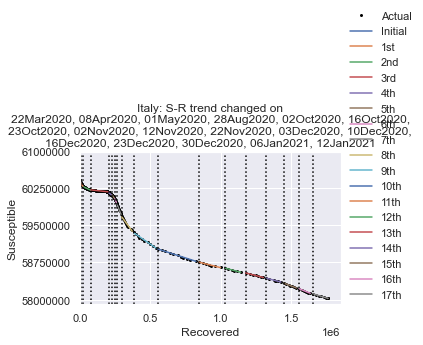


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...
	12th phase (10Dec2020 - 15Dec2020): finished  387 trials in 0 min 20 sec
	16th phase (23Oct2020 - 01Nov2020): finished   91 trials in 0 min 10 sec
	 5th phase (03Dec2020 - 09Dec2020): finished  159 trials in 0 min 20 sec
	11th phase (30Dec2020 - 05Jan2021): finished  159 trials in 0 min 20 sec
	 9th phase (02Nov2020 - 11Nov2020): finished  250 trials in 0 min 30 sec
	 2nd phase (16Dec2020 - 22Dec2020): finished  101 trials in 0 min 10 sec
	 0th phase (16Oct2020 - 22Oct2020): finished   78 trials in 0 min 10 sec
	17th phase (28Aug2020 - 01Oct2020): finished 1310 trials in 3 min  2 sec
	 4th phase (01May2020 - 27Aug2020): finished 1315 trials in 3 min  2 sec
	 1st phase (02Oct2020 - 15Oct2020): finished 1370 trials in 3 min  1 sec
	13th phase (06Jan2021 - 11Jan2021): finished  257 trials in 0 min 20 sec
	10th phase (08Apr2020 - 30Apr2020): finished 1369 trials in 3 min  2 sec
	15th phase (23Dec2020 - 29Dec2020): fi

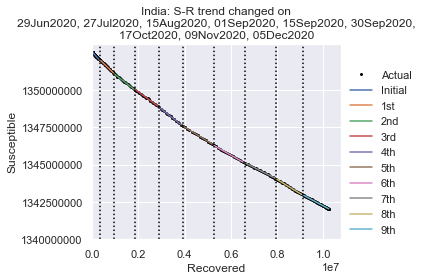


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...
	 6th phase (01Sep2020 - 14Sep2020): finished  692 trials in 0 min 40 sec
	 4th phase (30Sep2020 - 16Oct2020): finished  251 trials in 0 min 20 sec
	 1st phase (09Nov2020 - 04Dec2020): finished  466 trials in 0 min 40 sec
	 3rd phase (05Dec2020 - 19Jan2021): finished  507 trials in 1 min  0 sec
	 2nd phase (13Feb2020 - 28Jun2020): finished 1476 trials in 3 min  1 sec
	 5th phase (15Aug2020 - 31Aug2020): finished 1531 trials in 3 min  1 sec
	 0th phase (29Jun2020 - 26Jul2020): finished 1494 trials in 3 min  1 sec


In [ ]:
countries = ["Italy", "India"]
for country in countries:
    s = cs.Scenario(jhu_data, population_data, country=country)
    days, df_periods = s.estimate_delay(oxcgrt_data)

    s.trend()
    s.estimate(cs.SIRF)
    tracker = s.track()
    tracker = tracker.set_index("Date")
    tracker = tracker.groupby("Date").mean()
    tracker = tracker.shift(days)
    ox_df = oxcgrt_data.cleaned()
    ox_df = ox_df[ox_df["Country"] == country]
    ox_df = ox_df.groupby("Date").mean()
    merged = pd.merge(ox_df.reset_index(), tracker.reset_index(), on="Date", how="inner")

    measures = ox_df.columns
    interests = ["theta", "kappa", "rho", "sigma", "1/gamma [day]", "alpha1 [-]",  "1/alpha2 [day]", "1/beta [day]", "Measure"]
    params_total = pd.DataFrame(columns=interests)

    for i in range(len(measures)):
        measure = measures[i]
        values = ox_df[measure].values
        high = np.max(values)
        dates = ox_df[ox_df[measure] == high].reset_index()["Date"]
        subset = tracker.reset_index()[tracker.reset_index()["Date"].isin(dates)]
        means_df = subset.mean()[interests[:-1]]
        means_df["Measure"] = measure
        params_total.loc[i] = means_df
    params_total = params_total.set_index("Measure")
    params_total = params_total.reset_index()

    all_infecteds = pd.DataFrame()
    target = "Infected"
    measures_new = ['School_closing', 'Workplace_closing', 'Cancel_events',
           'Gatherings_restrictions', 'Transport_closing',
           'Stay_home_restrictions', 'Internal_movement_restrictions',
           'International_movement_restrictions']

    for measure in measures_new:
        name = measure
        selection = params_total[params_total["Measure"] == name]
        preset_dict = {
            "theta": selection["theta"].values[0],
            "kappa": selection["kappa"].values[0],
            "sigma": selection["sigma"].values[0],
            "rho": selection["rho"].values[0]
        }
        print(measure, preset_dict)
        s.summary()

        s.clear(name=name)
        s.add(name=name, 
              end_date='01Mar2021',
              **preset_dict,
              mode=cs.SIRF)
        records = s.simulate(name=name, show_figure=False)
        all_infecteds[measure] = records[target]

    all_infecteds["Date"] = records["Date"]
    all_infecteds.to_pickle("figures/pickles/" + country + "measures")
    all_infecteds_subsection = all_infecteds.query("Date>='2021-01-01'")